In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()
            

(242, 531, 3)


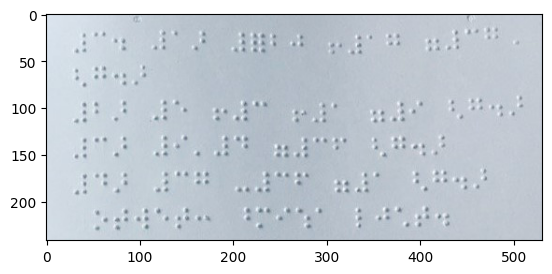

In [4]:
im = cv2.imread('data/braille.jpeg')
print(im.shape)
plt.imshow(im)

(242, 531)


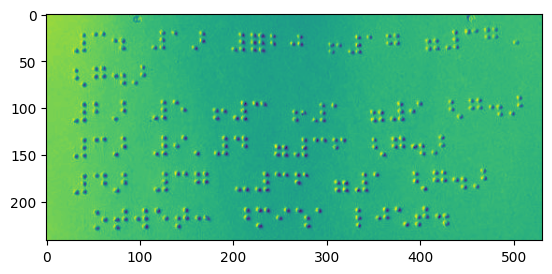

In [5]:
bw_im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
print(bw_im.shape)
plt.imshow(bw_im)

(242, 531)


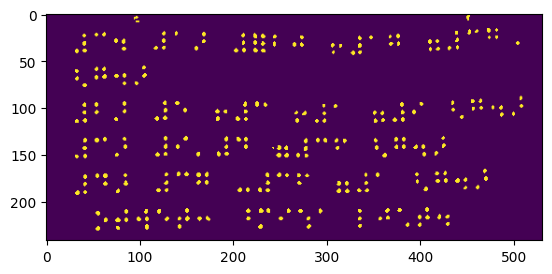

In [6]:
im = cv2.blur(bw_im, (3,3))
im = cv2.adaptiveThreshold(im, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                          cv2.THRESH_BINARY_INV, 5, 4)
im = cv2.medianBlur(im, 3)
_,im = cv2.threshold(im, 0,255, cv2.THRESH_OTSU)
im = cv2.GaussianBlur(im, (3,3), 0)
_,im = cv2.threshold(im, 0, 255, cv2.THRESH_OTSU)
print(im.shape)
plt.imshow(im)

In [7]:
orb = cv2.ORB_create(5000)
f,d = orb.detectAndCompute(im,None)
print(f"First 5 points: { [f[i].pt for i in range(5)]}")

First 5 points: [(307.20001220703125, 40.80000305175781), (297.6000061035156, 114.00000762939453), (423.6000061035156, 133.20001220703125), (242.40000915527344, 144.0), (103.68000793457031, 57.60000228881836)]


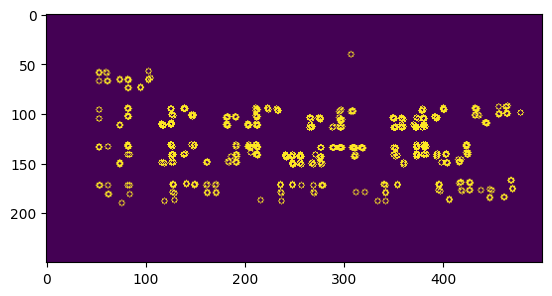

In [8]:
def plot_dots(dots):
    img = np.zeros((250,500))
    for x in dots:
        cv2.circle(img,(int(x[0]),int(x[1])),3,(255,0,0))
    plt.imshow(img)
pts = [x.pt for x in f]
plot_dots(pts)

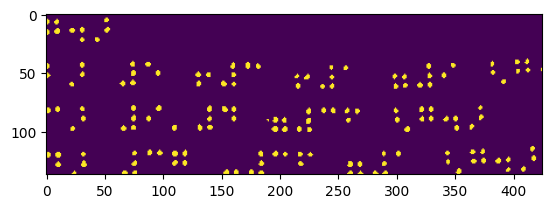

In [9]:
min_x, min_y, max_x, max_y = [int(f([z[i] for z in pts])) for f in (min,max) for i in (0,1)]
min_y+=13
plt.imshow(im[min_y:max_y,min_x:max_x])

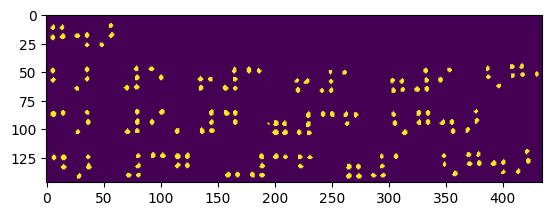

In [10]:
off = 5
src_pts = np.array([(min_x-off,min_y-off), (min_x-off,max_y+off),
                    (max_x+off,min_y-off), (max_x+off,max_y+off)])
w = int(max_x-min_x+off*2)
h = int(max_y-min_y+off*2)
dst_pst = np.array([(0,0),(0,h),(w,0),(w,h)])
ho,m = cv2.findHomography(src_pts,dst_pst)
trim = cv2.warpPerspective(im,ho,(w,h))
plt.imshow(trim)

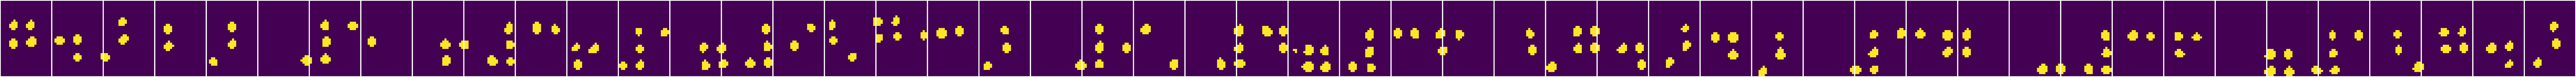

In [11]:
char_h = 36
char_w = 24

def slice(img):
    dy,dx = img.shape
    y = 0
    while y+char_h<dy:
        x=0
        while x+char_w<dx:
            if np.max(img[y:y+char_h,x:x+char_w])>0:
                yield img[y:y+char_h,x:x+char_w]
            x+=char_w
        y+=char_h
sliced = list(slice(trim))
display_images(sliced)

Total frames: 876


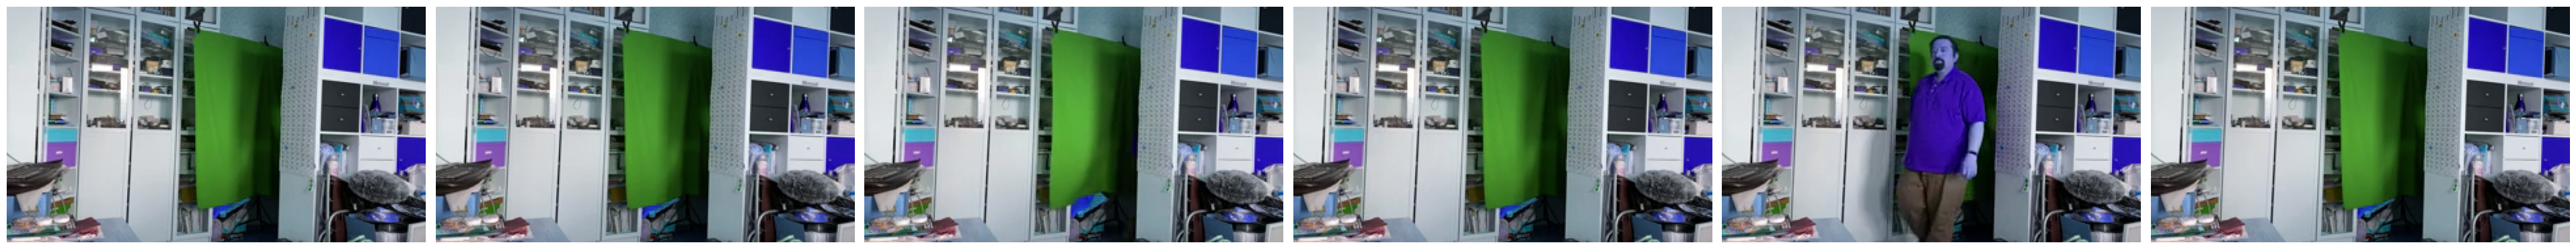

In [12]:
vid = cv2.VideoCapture('data/motionvideo.mp4')

c = 0
frames = []
while vid.isOpened():
    ret, frame = vid.read()
    if not ret:
        break
    frames.append(frame)
    c+=1
vid.release()
print(f"Total frames: {c}")
display_images(frames[::150])


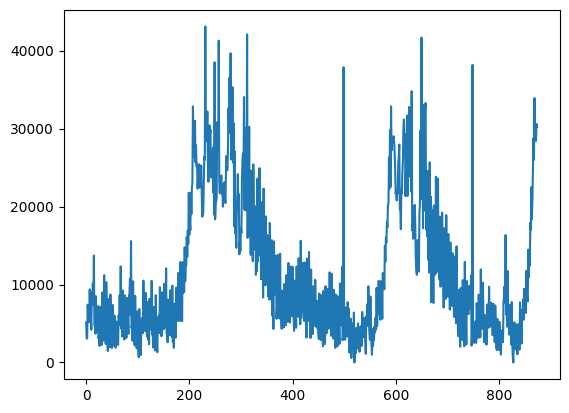

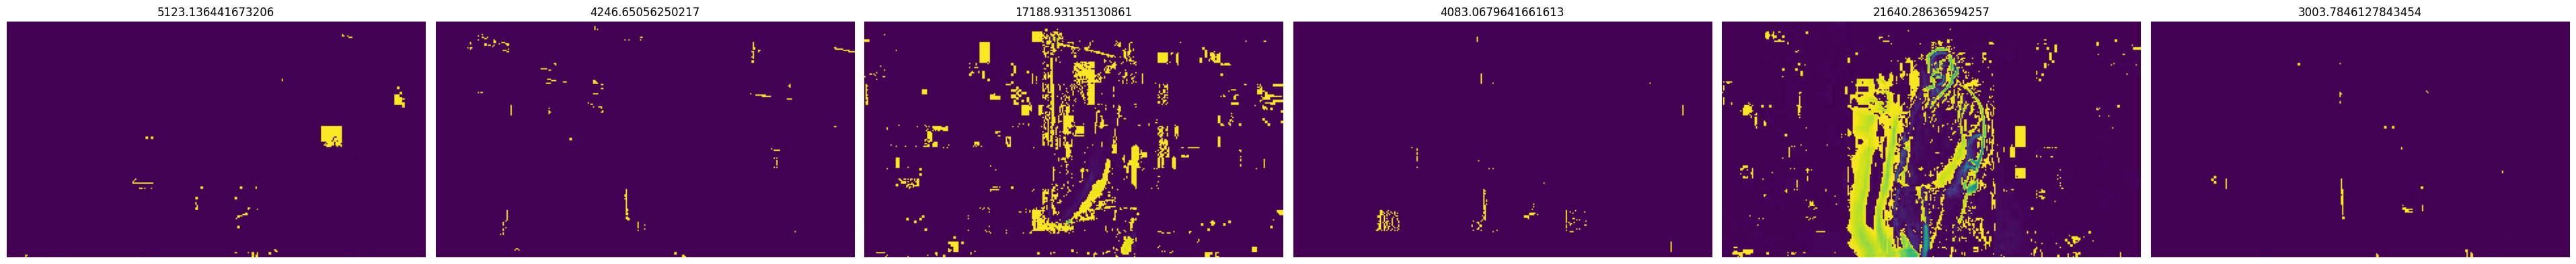

In [13]:

bwframes = [cv2.cvtColor(x,cv2.COLOR_BGR2GRAY) for x in frames]
diffs = [(p2-p1) for p1,p2 in zip(bwframes[:-1],bwframes[1:])]
diff_amps = np.array([np.linalg.norm(x) for x in diffs])
plt.plot(diff_amps)
display_images(diffs[::150],titles=diff_amps[::150])